In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
!pip install prophet
from prophet import Prophet
from matplotlib import style
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from google.colab import drive
drive.mount('/content/drive')
np.random.seed(0)

Mounted at /content/drive


In [2]:
layoffs_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/layoffs.csv")
layoffs_df.head()

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
0,New Work,Hamburg,Consumer,400.0,NaN,2024-01-11,Post-IPO,Germany,NaN
1,Playtika,Tel Aviv,Consumer,300.0,0.10,2024-01-11,Post-IPO,Israel,NaN
2,Discord,SF Bay Area,Consumer,170.0,0.17,2024-01-11,Series H,United States,995.0
3,Inmobi,Bengaluru,Marketing,125.0,0.05,2024-01-11,Unknown,India,320.0
4,Audible,New York City,Media,100.0,0.05,2024-01-11,Acquired,United States,14.0


In [3]:
layoffs_df.shape

(3313, 9)

In [4]:
missing_df=layoffs_df.isnull().sum()
missing_df

company                   0
location                  1
industry                  1
total_laid_off         1124
percentage_laid_off    1172
date                      0
stage                     7
country                   0
funds_raised            351
dtype: int64

In [5]:
#to find the percentage of cells with null values:
total_cells = np.product(layoffs_df.shape)
missing_cells = missing_df.sum()
percentage_miss = missing_cells/total_cells*100
percentage_miss

8.907670121071872

In [6]:

#we wouldn't have to see row corresponding to the miss in column location and industry
layoffs_df[layoffs_df.location.isnull()]


,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
212,Product Hunt,NaN,Consumer,NaN,0.6,2023-10-09,Acquired,United States,NaN


since the company ProductHunt's total_laid_off and funds raised are not available, it makes sense to delete the row, but deleting, i think some data needs to be recorded.


In [7]:
# grouping based on the stage of the company:
stage_df = layoffs_df.groupby('stage').size()
stage_df


stage
Acquired          270
Post-IPO          666
Private Equity     60
Seed              109
Series A          233
Series B          394
Series C          386
Series D          293
Series E          156
Series F           93
Series G           21
Series H           32
Series I            8
Series J            8
Subsidiary         19
Unknown           558
dtype: int64

In [26]:
#deleting the ProductHunt col as it is not useful in our analysis
layoffs_df = layoffs_df[layoffs_df["location"].notnull()]



In [9]:
layoffs_df[layoffs_df.industry.isnull()]

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
254,Appsmith,SF Bay Area,NaN,35.0,0.25,2023-09-22,Series B,United States,51.0


we find that this row contains some useful data, but it has empty value in the industry column, by google search we find that appsmith is a software based company that build internal applications, so we need to update it.

In [27]:
layoffs_df.at[254, 'industry'] = "software"


to have clean dataset , we also need to delete rows with both total_laid_off/percentage_laid_off and funds_raised as nan.

In [28]:
layoffs_df.dropna(subset=['total_laid_off', 'funds_raised'], how='any', inplace=True)
layoffs_df = layoffs_df.copy()



In [12]:
layoffs_df.reset_index(drop=True, inplace=True)
layoffs_df.query("company	== 'Appsmith'") #check

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
117,Appsmith,SF Bay Area,software,35.0,0.25,2023-09-22,Series B,United States,51.0


For Nan values in stage, change it to Unknown


In [13]:
layoffs_df.stage=layoffs_df.stage.fillna("Unknown")



In [14]:
layoffs_df.date.dtype

dtype('O')

the date column is in object type ('O') and it would be convinent to convert it to a datetime datatype.

In [15]:
layoffs_df.date = pd.to_datetime(layoffs_df['date'], format="%Y-%m-%d")
layoffs_df.date.dtype

dtype('<M8[ns]')

Our dataset is now clean and pre processed !

The intention behind the data analysis is to find the following :

1) Finding the months in which layoffs are high and low, to sense a pattern

2) To find which stage company offers secure jobs


In [16]:
print(layoffs_df['date'].max())
print(layoffs_df['date'].min())




2024-01-11 00:00:00
2020-03-11 00:00:00


In [17]:
layoffs_df["month"] = layoffs_df['date'].dt.to_period('M')
month_sum = layoffs_df.groupby('month')['total_laid_off'].sum().reset_index()
month_sum['month'] = month_sum['month'].dt.to_timestamp()
print(month_sum)
month_sum_20 = month_sum[month_sum['month'].dt.year == 2020 ].reset_index(drop = True)
month_sum_21= month_sum[month_sum['month'].dt.year == 2021 ].reset_index(drop = True)
month_sum_22 = month_sum[month_sum['month'].dt.year == 2022 ].reset_index(drop = True)
month_sum_23= month_sum[month_sum['month'].dt.year == 2023 ].reset_index(drop = True)
month_sum_24 = month_sum[month_sum['month'].dt.year == 2024 ].reset_index(drop = True)
month_sum_20['month'] = pd.to_datetime(month_sum_20['month'], format='%Y-%m')
month_sum_21['month'] = pd.to_datetime(month_sum_21['month'], format='%Y-%m')
month_sum_22['month'] = pd.to_datetime(month_sum_22['month'], format='%Y-%m')
month_sum_23['month'] = pd.to_datetime(month_sum_23['month'], format='%Y-%m')
month_sum_24['month'] = pd.to_datetime(month_sum_24['month'], format='%Y-%m')



        month  total_laid_off
0  2020-03-01          8981.0
1  2020-04-01         25271.0
2  2020-05-01         22699.0
3  2020-06-01          7046.0
4  2020-07-01          2737.0
5  2020-08-01          1969.0
6  2020-09-01           609.0
7  2020-10-01           450.0
8  2020-11-01           219.0
9  2020-12-01           774.0
10 2021-01-01          6813.0
11 2021-02-01           855.0
12 2021-03-01            47.0
13 2021-04-01           261.0
14 2021-06-01          2434.0
15 2021-07-01            80.0
16 2021-08-01          1867.0
17 2021-09-01           161.0
18 2021-10-01            22.0
19 2021-11-01          2070.0
20 2021-12-01          1200.0
21 2022-01-01           510.0
22 2022-02-01          3685.0
23 2022-03-01          5714.0
24 2022-04-01          4078.0
25 2022-05-01         12685.0
26 2022-06-01         16684.0
27 2022-07-01         15888.0
28 2022-08-01         12539.0
29 2022-09-01          5881.0
30 2022-10-01         12906.0
31 2022-11-01         52390.0
32 2022-12

,month,total_laid_off
0,2024-01-01,4862.0


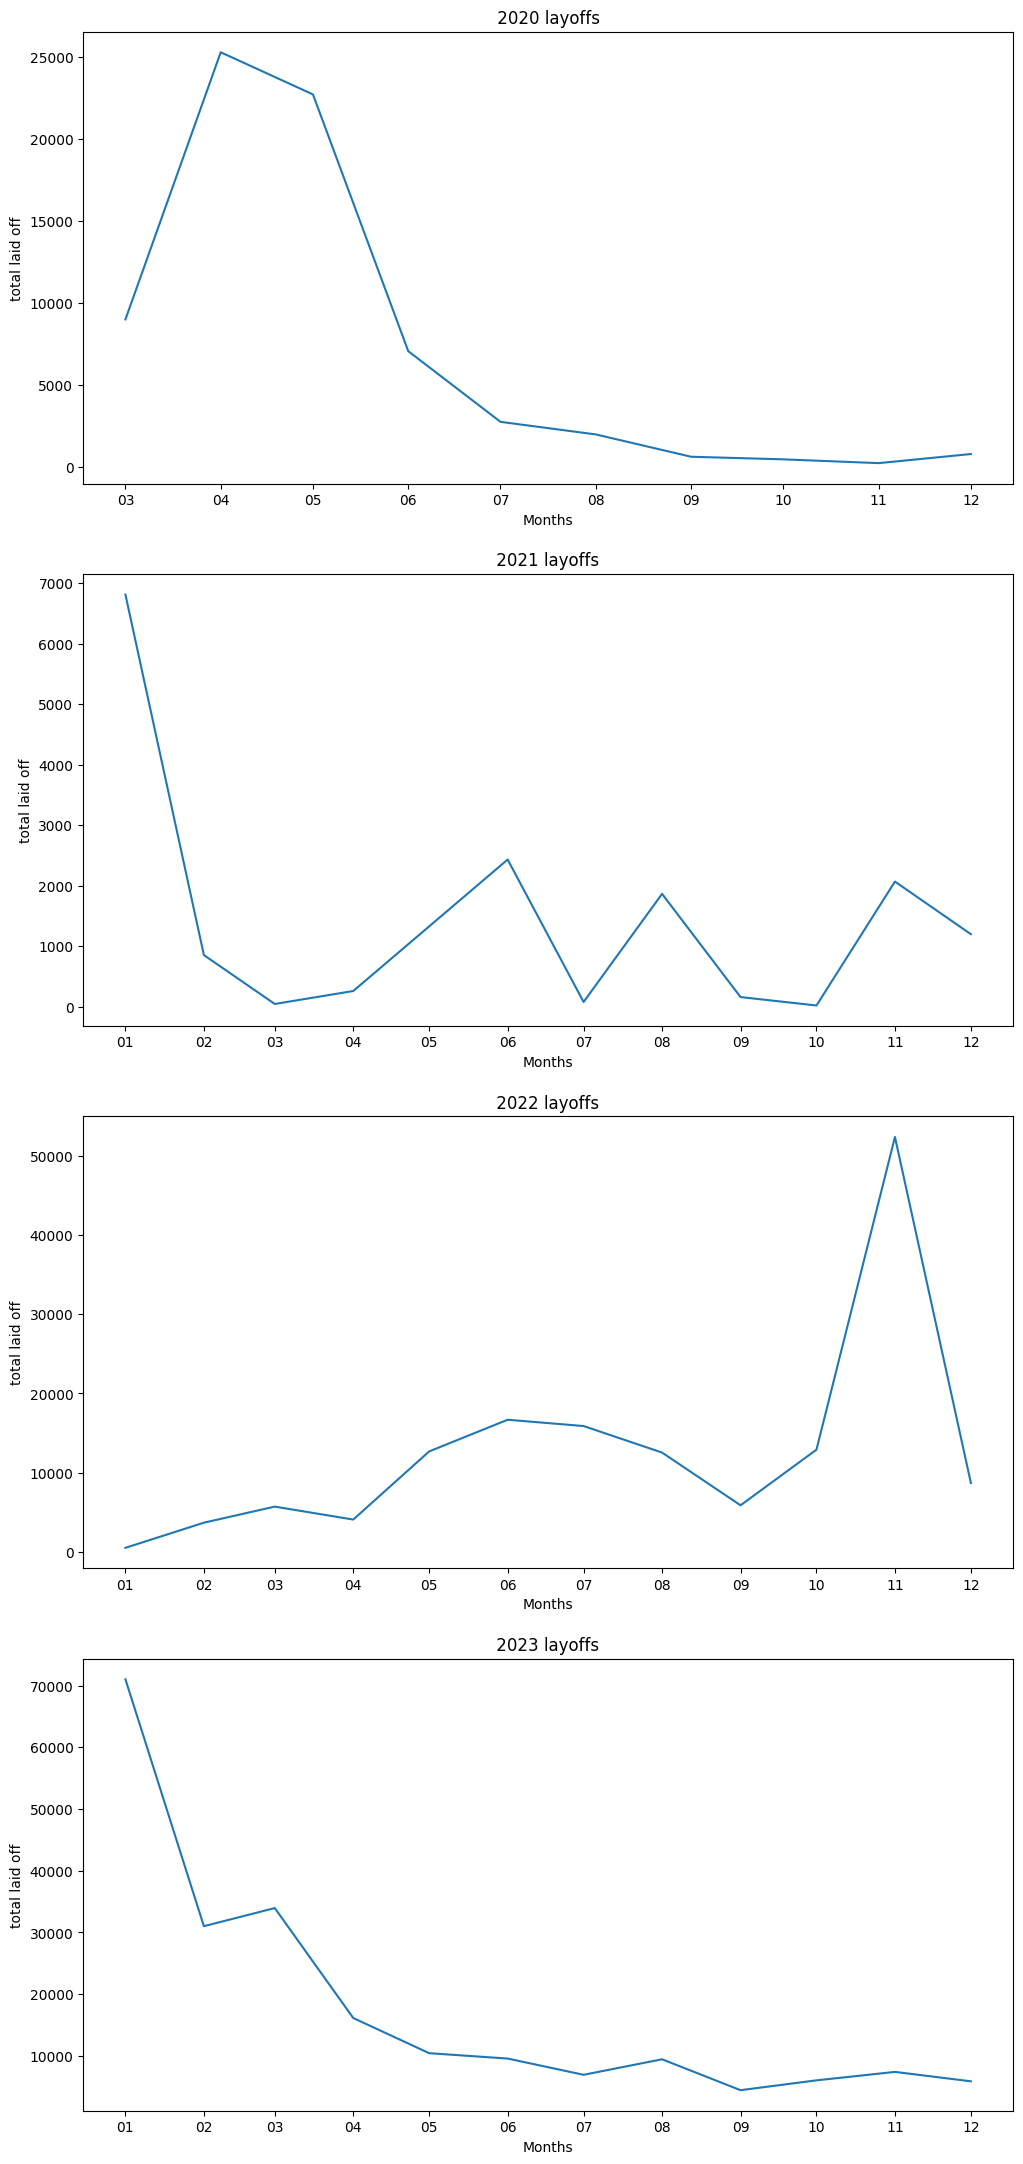

In [19]:
fig1 , axes1 = plt.subplots(figsize=(12,27), nrows = 4,ncols=1)

for ax in axes1:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.set_xlabel("Months")
    ax.set_ylabel("total laid off")



axes1[0].plot(month_sum_20['month'] , month_sum_20['total_laid_off'])
axes1[0].set_title(" 2020 layoffs ")



axes1[1].plot(month_sum_21['month'] , month_sum_21['total_laid_off'])
axes1[1].set_title(" 2021 layoffs ")


axes1[2].plot(month_sum_22['month'] , month_sum_22['total_laid_off'])
axes1[2].set_title(" 2022 layoffs ")

axes1[3].plot(month_sum_23['month'] , month_sum_23['total_laid_off'])
axes1[3].set_title(" 2023 layoffs ")


month_sum_24




DEBUG:cmdstanpy:input tempfile: /tmp/tmpeqbl6ln2/il80e8iw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeqbl6ln2/udnhq2_k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5676', 'data', 'file=/tmp/tmpeqbl6ln2/il80e8iw.json', 'init=/tmp/tmpeqbl6ln2/udnhq2_k.json', 'output', 'file=/tmp/tmpeqbl6ln2/prophet_modeln2p1qlbv/prophet_model-20240202081717.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
08:17:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:17:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Predicted month with the most laid off in 2024: February 2024


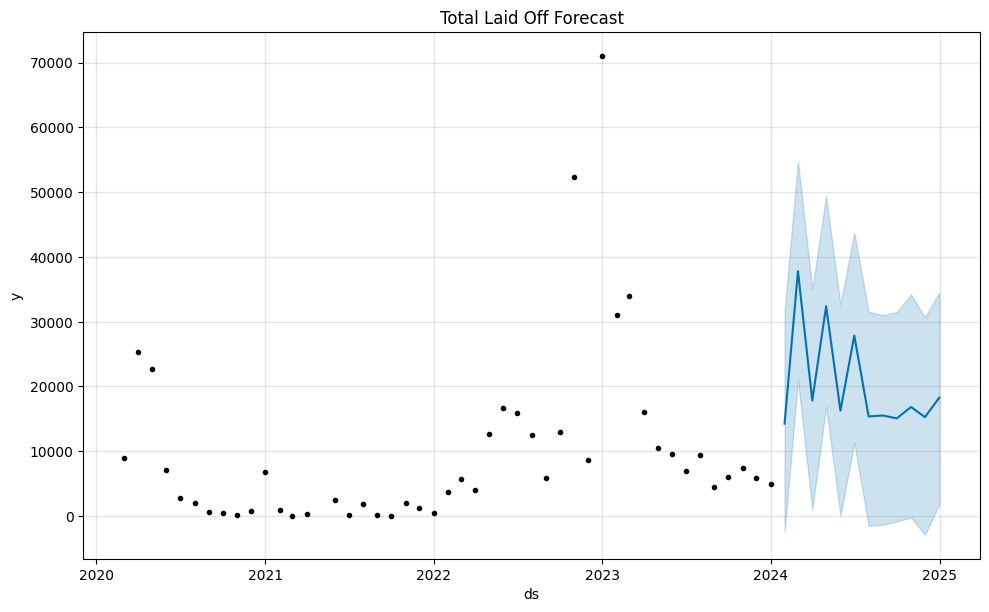

In [18]:
# Prepare data for Prophet
prophet_data = month_sum.rename(columns={'month': 'ds', 'total_laid_off': 'y'})

# Create and fit the model
model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
model.add_seasonality(name='monthly', period=30.44, fourier_order=5)  # Monthly seasonality
model.fit(prophet_data)

# Create a future DataFrame for predictions
future = model.make_future_dataframe(periods=12, freq='M', include_history=False)

# Generate predictions
forecast = model.predict(future)

# Print the forecast for 2024
forecast_2024 = forecast[forecast['ds'].dt.year == 2024]
max_laid_off_month_2024 = forecast_2024.loc[forecast_2024['yhat'].idxmax()]

print("Predicted month with the most laid off in 2024:", max_laid_off_month_2024['ds'].strftime('%B %Y'))

# Plot the forecast
fig = model.plot(forecast)
plt.title('Total Laid Off Forecast')
plt.show()

In [21]:
layoffs_df = layoffs_df.dropna( subset = ['percentage_laid_off'] ).reset_index(drop = True)
stage_grouped = layoffs_df.groupby('stage')['percentage_laid_off'].mean().reset_index()
stage_grouped['stage']



0           Acquired
1           Post-IPO
2     Private Equity
3               Seed
4           Series A
5           Series B
6           Series C
7           Series D
8           Series E
9           Series F
10          Series G
11          Series H
12          Series I
13          Series J
14        Subsidiary
15           Unknown
Name: stage, dtype: object

Notes:

Seed: This is typically the initial stage of funding, where the company is in its infancy. Seed funding is used to prove a concept, conduct market research, and develop a minimum viable product (MVP).

Series A: After the seed stage, companies often seek Series A funding to scale their operations, expand their team, and further develop their product or service. This stage is characterized by more substantial funding amounts.

Series B: At this stage, companies have usually established a market presence and are looking to accelerate growth. Series B funding is often used to scale operations, increase market share, and enhance product offerings.

Series C, D, E, etc.: These subsequent rounds of funding follow a similar pattern, with each round providing additional capital for further expansion. Companies at these stages are typically more mature, and the funding may be used for international expansion, acquisitions, or preparing for an initial public offering (IPO).

Post-IPO: After a company goes public and its shares are traded on the stock market, it enters the post-IPO stage. At this point, the company can continue to raise capital through the stock market by issuing additional shares.

Private Equity: This is a broader category that refers to investments made in private companies. Private equity firms invest in established companies with the goal of achieving significant returns. Private equity transactions can involve various stages of a company's lifecycle.

Subsidiary: A subsidiary is a company that is controlled by another company, known as the parent company. The parent company may own all or a majority of the subsidiary's shares. Subsidiaries can operate independently or as part of a larger corporate structure.

Unknown: Some companies may not disclose or may not be clear about their funding stage, and they may be categorized as "Unknown" in certain datasets or analyses.

Text(0.5, 1.0, ' Analysing which stage company offers job security')

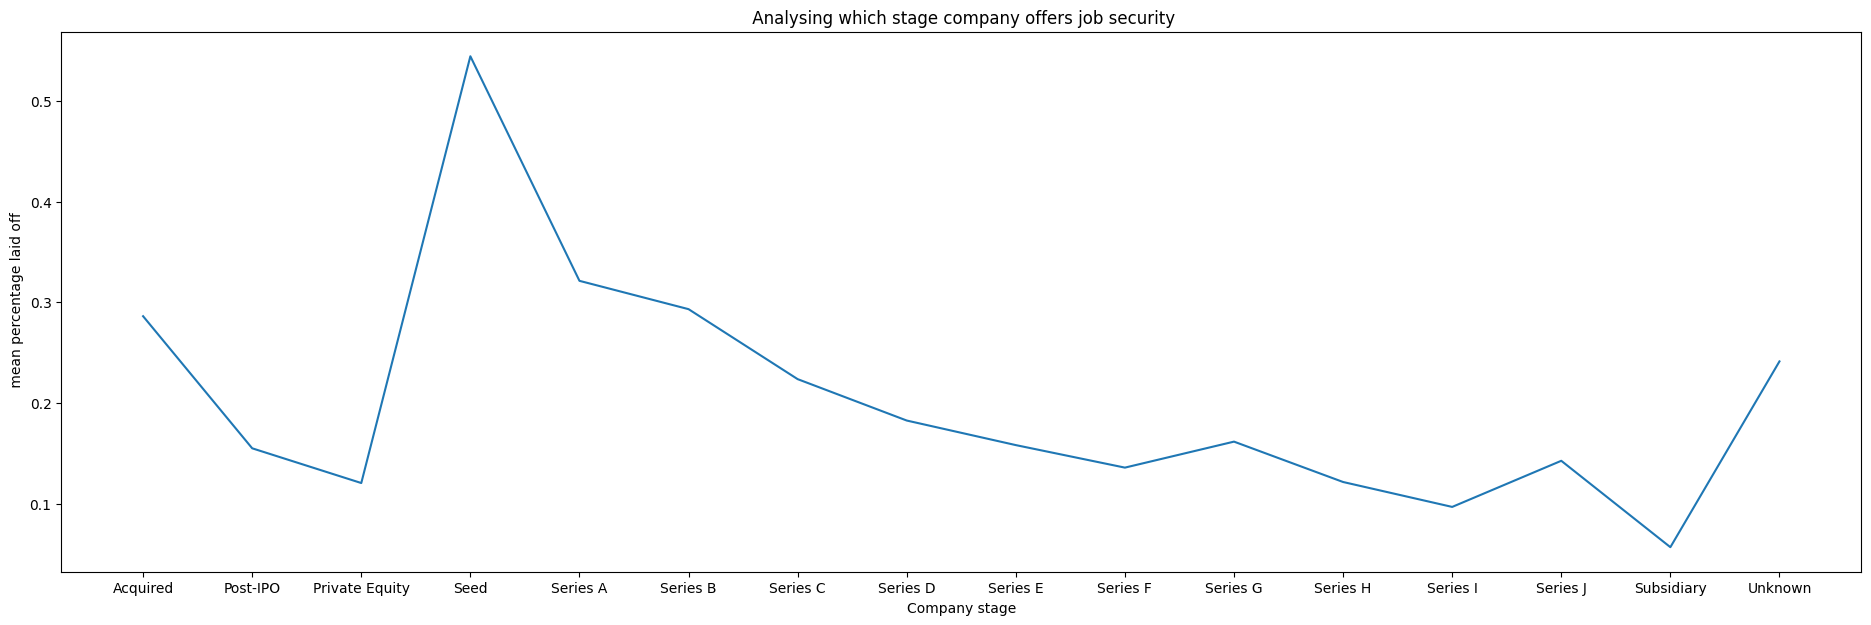

In [22]:
fig2 = plt.figure(figsize=(20,6))
axes = fig2.add_axes([0.1,0.1,0.9,0.9])
axes.plot(stage_grouped['stage'] , stage_grouped['percentage_laid_off'])
axes.set_xlabel("Company stage")
axes.set_ylabel(" mean percentage laid off")
axes.set_title(" Analysing which stage company offers job security")



<Axes: ylabel='percentage_laid_off'>

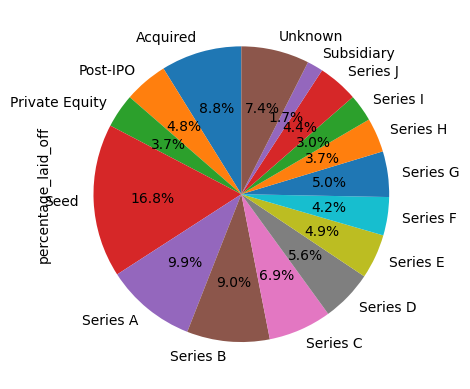

In [23]:
stage_grouped.plot.pie(y='percentage_laid_off', labels=stage_grouped['stage'], autopct='%1.1f%%', startangle=90, legend=False)

From our analysis, it is clear that companies in subsidary stage offers better job security.
It is also evident that employees in companies- in its initial stages are more prone to the pattern.
Also, by the forecasting, we see that the layoffs this year will be higher in the months of feb and april.